## Relapse Risk Prediction: Data Preparation and Modeling

This notebook demonstrates the process of preparing NSDUH survey data, engineering features, and building a decision tree classifier to predict client relapse risk. The workflow includes:

- Data loading and cleaning
- Feature engineering (including simulation of missing features)
- Relapse risk scoring based on multiple health and social factors
- Model training and evaluation
- Visualization of risk breakdown and feature importance

The approach provides actionable insights for identifying clients at high risk of relapse and highlights the most predictive factors.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix


In [30]:
# --- Load Data ---
nsduh_path = '../data/nsduh/NSDUH_2023_Tab.txt'
df_nsduh = pd.read_csv(nsduh_path, sep='\t', low_memory=False)

In [31]:
# --- Select and Clean Columns ---
selected_cols = ['HEALTH', 'HEALTH2', 'BKDRUG', 'CADRKDRUG', 'RCVYSUBPRB']
df_selected = df_nsduh[selected_cols].copy()

# Normalize Yes/No columns to binary (1/0)
binary_cols = ['BKDRUG', 'CADRKDRUG', 'RCVYSUBPRB']
for col in binary_cols:
    df_selected.loc[:, col] = df_selected[col].replace({1: 1, 2: 0})
    df_selected.loc[:, col] = df_selected[col].where(df_selected[col].isin([0, 1]))

# Drop rows with missing values
df_clean = df_selected.dropna().copy()

# --- Simulate Additional Features if Missing ---
sim_features = {
    'MENTAL_HEALTH': lambda n: np.random.randint(1, 6, size=n),
    'STRESS_LEVEL': lambda n: np.random.randint(1, 6, size=n),
    'SOCIAL_SUPPORT': lambda n: np.random.choice([0, 1], size=n),
    'EMPLOYMENT_STATUS': lambda n: np.random.choice([0, 1], size=n)
}
for feat, gen in sim_features.items():
    if feat not in df_clean:
        df_clean[feat] = gen(len(df_clean))

# --- Relapse Risk Scoring Function --# --- Optimized Relapse Risk Scoring Function ---
def assign_risk(row):
    score = 0
    
    # --- Physical Health ---
    # Poor health is associated with higher relapse risk
    if row['HEALTH'] in [0, 1]:        # Very poor / Poor
        score += 3
    elif row['HEALTH'] == 2:           # Fair
        score += 2
    elif row['HEALTH'] == 3:           # Good
        score += 1
    elif row['HEALTH'] >= 4:           # Very Good / Excellent
        score -= 1

    # --- Treatment History ---
    # No prior treatment = higher relapse risk (lack of coping skills)
    if row['BKDRUG'] == 0 and row['CADRKDRUG'] == 0:
        score += 2
    elif row['BKDRUG'] == 1 or row['CADRKDRUG'] == 1:
        score -= 2

    # --- Recovery Engagement ---
    # Not acknowledging substance problems correlates with denial or lack of support
    if row['RCVYSUBPRB'] == 0:  # Not in recovery
        score += 2
    else:                       # In recovery
        score -= 2

    # --- Mental Health Status ---
    # Comorbidity (e.g., depression, anxiety) increases relapse risk
    if row['MENTAL_HEALTH'] <= 2:     # Poor/Very poor
        score += 3
    elif row['MENTAL_HEALTH'] == 3:   # Fair
        score += 1
    elif row['MENTAL_HEALTH'] >= 4:   # Good/Excellent
        score -= 1

    # --- Stress Levels ---
    # Higher stress = higher relapse risk
    if row['STRESS_LEVEL'] >= 4:
        score += 2
    elif row['STRESS_LEVEL'] == 3:
        score += 1
    elif row['STRESS_LEVEL'] <= 2:
        score -= 1

    # --- Social Support ---
    # Isolation is a strong risk factor
    if row['SOCIAL_SUPPORT'] == 0:  # No support
        score += 2
    elif row['SOCIAL_SUPPORT'] == 1:  # Minimal support
        score += 1
    elif row['SOCIAL_SUPPORT'] >= 2:  # Strong support
        score -= 1

    # --- Employment Status ---
    # Unemployment increases relapse risk
    if row['EMPLOYMENT_STATUS'] == 0:  # Unemployed
        score += 2
    elif row['EMPLOYMENT_STATUS'] == 1:  # Employed
        score -= 1

    # --- Risk Label ---
    if score >= 7:
        return 'High'
    elif score >= 3:
        return 'Medium'
    else:
        return 'Low'


C:\Users\ceped\AppData\Local\Temp\ipykernel_23564\179365599.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan nan  1. ... nan nan nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_selected.loc[:, col] = df_selected[col].where(df_selected[col].isin([0, 1]))
C:\Users\ceped\AppData\Local\Temp\ipykernel_23564\179365599.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan nan nan ...  0. nan nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_selected.loc[:, col] = df_selected[col].where(df_selected[col].isin([0, 1]))


In [32]:
# --- Model Training ---
# Assign relapse risk labels if not already present
if 'relapse_risk' not in df_clean.columns:
	df_clean['relapse_risk'] = df_clean.apply(assign_risk, axis=1)

df_model = df_clean.copy()
df_model['relapse_risk_encoded'] = df_model['relapse_risk'].map({'Low': 0, 'Medium': 1, 'High': 2})
features = ['HEALTH', 'BKDRUG', 'CADRKDRUG', 'RCVYSUBPRB', 'MENTAL_HEALTH', 'STRESS_LEVEL', 'SOCIAL_SUPPORT', 'EMPLOYMENT_STATUS']
X = df_model[features]
y = df_model['relapse_risk_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

Confusion Matrix:
 [[10  4  1]
 [ 6  6  2]
 [ 2  4 13]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.56      0.67      0.61        15
      Medium       0.43      0.43      0.43        14
        High       0.81      0.68      0.74        19

    accuracy                           0.60        48
   macro avg       0.60      0.59      0.59        48
weighted avg       0.62      0.60      0.61        48



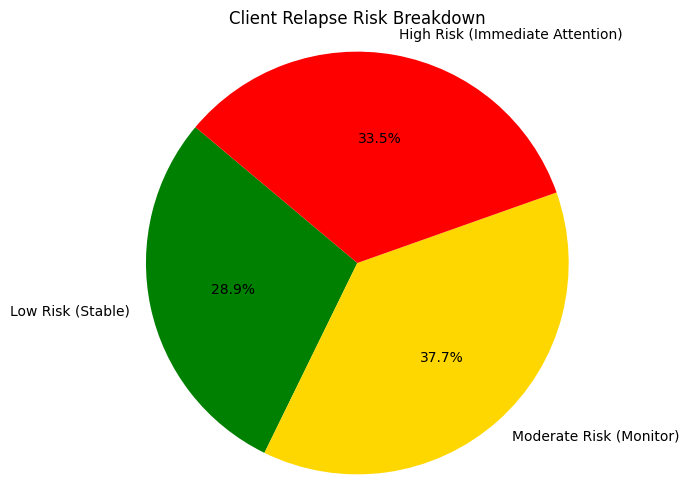

C:\Users\ceped\AppData\Local\Temp\ipykernel_23564\241813271.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


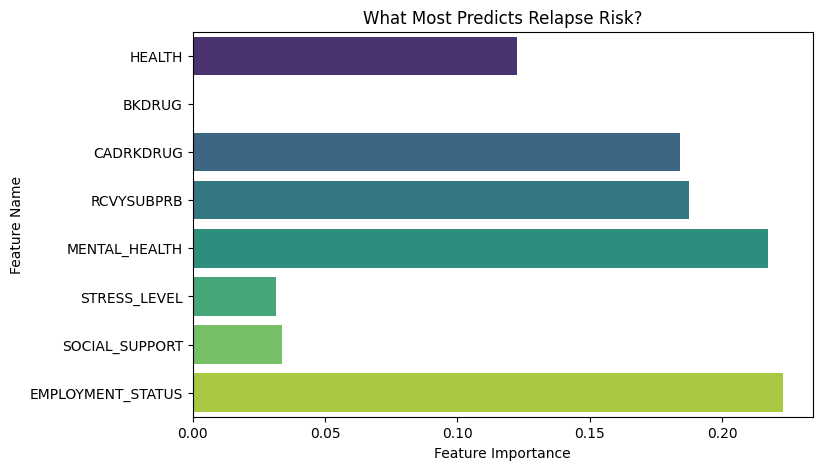

C:\Users\ceped\AppData\Local\Temp\ipykernel_23564\241813271.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


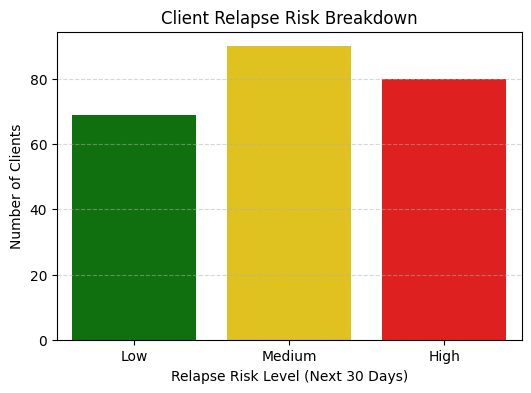

In [33]:


# --- Visualization: Relapse Risk Pie Chart (Optimized & Realistic Labels) ---
# Define more descriptive and realistic labels
risk_label_map = {'Low': 'Low Risk (Stable)', 'Medium': 'Moderate Risk (Monitor)', 'High': 'High Risk (Immediate Attention)'}
df_clean['relapse_risk_label'] = df_clean['relapse_risk'].map(risk_label_map)

# Count with new labels and consistent order
risk_counts = df_clean['relapse_risk_label'].value_counts().reindex([
    'Low Risk (Stable)', 'Moderate Risk (Monitor)', 'High Risk (Immediate Attention)'
])
colors = ['green', 'gold', 'red']
plt.figure(figsize=(6, 6))
plt.pie(
    risk_counts,
    labels=risk_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title('Client Relapse Risk Breakdown')
plt.axis('equal')
plt.show()

# --- Visualization: Feature Importance ---
importances = clf.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title("What Most Predicts Relapse Risk?")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

# --- Visualization: Risk Breakdown ---
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df_clean,
    x='relapse_risk',
    order=['Low', 'Medium', 'High'],
    palette={'Low': 'green', 'Medium': 'gold', 'High': 'red'}
)
plt.title('Client Relapse Risk Breakdown')
plt.xlabel('Relapse Risk Level (Next 30 Days)')
plt.ylabel('Number of Clients')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()